In [118]:
import nltk
import pandas as pd
import numpy as np
import re
from collections import Counter
from itertools import *
from pylab import *
import powerlaw

import seaborn as sns # poista?
from scipy import stats as sts # zipf, linreg, powerlaw
from scipy.stats import t

### Resources:
1. https://www.nltk.org/book/
2. Draw Zipf plot: https://finnaarupnielsen.wordpress.com/2013/10/22/zipf-plot-for-word-counts-in-brown-corpus/
3. Zipf plot Python 3: https://gist.github.com/ajnelson-nist/f93e07fca60d0fb42c5c
4. Estimate alpha: http://www-personal.umich.edu/~mejn/courses/2006/cmplxsys899/powerlaws.pdf (also, https://arxiv.org/pdf/0706.1062.pdf pages 6, 36,)
5. Powerlaw package: https://arxiv.org/pdf/1305.0215.pdf

Read data, tokenize and calculate frequencies and ranks.

In [13]:
files = ["flatland.txt", "panama-canal.txt"]
books = []

# Read data and save books to dict
for f in files:
    file = open(f, "r", encoding='utf-8')
    book = re.findall(r'(\b[A-Za-z][a-z]{2,15}\b)', file.read())
    books.append(book)
    file.close()

books = {'flatland.txt': books[0], 'panama-canal.txt': books[1]}

# Tokenize and count frequencies
tokens = {}
counts = {}
ranks = {}
freqs = {}
#indices = {}

for b in books:
    tokens_w_count = Counter(map(str.lower, books[b]))
    tokens[b] = sorted([k for k in tokens_w_count.keys()])
    counts[b] = np.array([tokens_w_count[k] for k in tokens[b]])
    ranks[b] = np.arange(1, len(counts[b]) + 1)
    indices = np.argsort(-counts[b])
    freqs[b] = counts[b][indices]


Define functions for finding specific information (for troubleshooting):

In [4]:
def getfreq(word, book):
    try:
        i = list(tokens[book]).index(word, 0, len(tokens[book]))
    except ValueError:
        print("Word not found.")
    else:
        print("Word: ", word)
        print("Freq: ", counts[book][i])
        #print("Rank: ", ranks[book][i])

# def getrank():

In [160]:
getfreq("the", "flatland.txt")

Word:  the
Freq:  2189


### Task 1.

Use appropriate NLTK coding (you can inspire from coding examples of the online NLTK book) in order to **plot the histogram of the twenty most frequent words** in each of the three ebooks. **Comment on the nature of these words** in terms of their relevance to the content of the ebook. Suggest your own approach to evaluate such relevancy.  

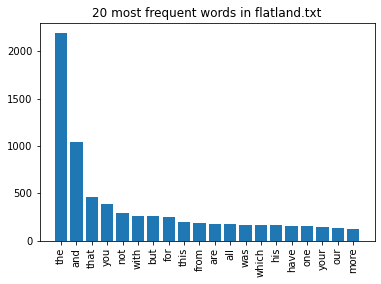

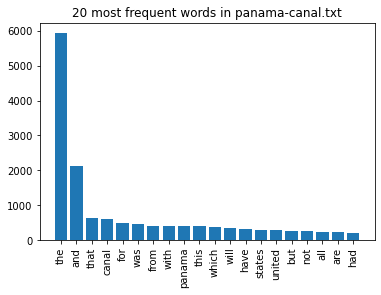

In [8]:
for b in books:
    df = pd.DataFrame({'word': tokens[b], 'count': counts[b]}).sort_values(by=['count'], ascending=False).head(20)
    #df = df.sort_values(by=['count']) # ascending for plot
    
    # Histogram of 20 most freq
    x = list(df.loc[:, 'word'])
    y = list(df.loc[:, 'count'])
    
    title("20 most frequent words in " + b)
    plt.bar(x, y)
    plt.xticks(rotation='vertical')
    plt.show() 

### Task 2 & 3.
2. Use the frequency of the words to fit the Zipf distribution for each ebook. Draw the zipf fitting cure for each ebook and comment on the goodness of fit.


3. We would like to **quantify the goodness of fit of the Zipf law** using the statistical confidence bound at 90% confidence. Ideally, we should obtain an upper curve and a lower curve around the Zipf law cure. If the fitting is statistically valid at 90% confidence, then all points should be located within this upper and lower curve. Test different values of the confidence value, e.g., 80%, 85%, 90% and 95% and report the number of points that fall outside the upper and lower bounds for each case.


#### Draw Zipf plots (log-log)

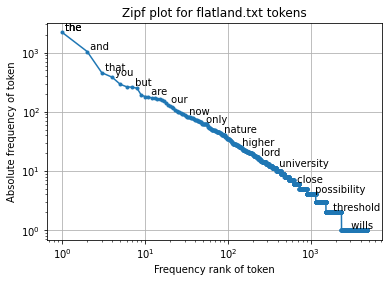

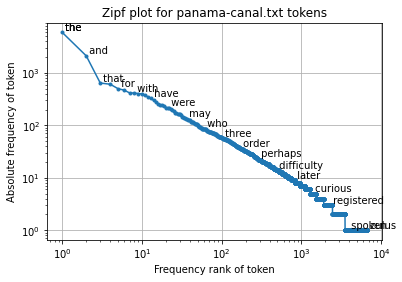

In [16]:
for b in books:
    indices = np.argsort(-counts[b])
    
    loglog(ranks[b], freqs[b], marker=".")
    title("Zipf plot for " + b + " tokens")
    xlabel("Log rank of token")
    ylabel("Log frequency of token")
    grid(True)
    for n in list(logspace(-0.5, log10(len(counts[b])), 20).astype(int)):
        # Not all words fit on x-axis; using try-except to break out of loop
        try:
            dummy = text(ranks[b][n], freqs[b][n], " " + tokens[b][indices[n]], 
                         verticalalignment = "bottom", horizontalalignment = "left")
        except IndexError:
            break
    show()

#### Fit Zipf curve

*...in practical situations we would often like to estimate $\alpha$ from observed data. One way to do this would be to fit the slope of the line in plots like Figs. 3b, c  or d, and this is the most commonly used method. Unfortunately, it is known to introduce systematic biases into the value of the exponent, so it should not be relied upon.*

(Source: http://www-personal.umich.edu/~mejn/courses/2006/cmplxsys899/powerlaws.pdf)

Estimator for shape parameter $\alpha$:

> $ \hat{\alpha} = 1 + n\left( \sum_{i=1}^n ln \frac{x_i}{x_{min}} \right)^{-1} $

Other ways to estimate $\alpha$:
- Maximum likelihood (for continuous variables, not a good choice here, a glance on this: https://www.johndcook.com/blog/2015/11/24/estimating-the-exponent-of-discrete-power-law-data/)
- Least squares

In [108]:
def ahat(n, rank):
    return 1 + ( n / sum(log(rank / min(rank))) )

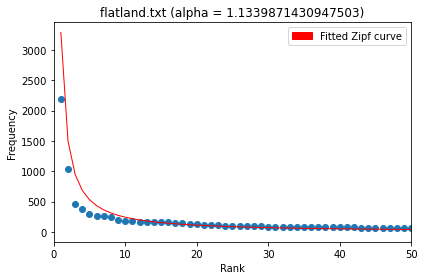

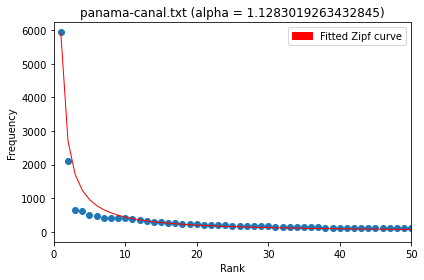

In [117]:
def zipfcurve():
    for b in books:
        # Estimate alpha
        alpha = ahat(len(ranks[b]), ranks[b])
    
        # Fit curve
        total = sum([freqs[b]])
        plt.title(str(b) + " (alpha = " + str(alpha) + ")")
        plt.scatter(ranks[b], freqs[b])
        plt.plot(ranks[b], sts.zipf.pmf(ranks[b], alpha) * total, lw=1, color='red')
        plt.ylabel("Frequency")
        plt.xlabel("Rank")
        plt.xlim(0, 50) # limit x-axis to better see the fit
        plt.tight_layout()
        red_patch = matplotlib.patches.Patch(color='red', label='Fitted Zipf curve')
        plt.legend(handles=[red_patch])
        plt.show()
        
zipfcurve()

#### Fit linear regression

Define functions:

In [43]:
def linreg(ranks, frequencies, ci_level):
    r = log(ranks)
    fr = log(frequencies)

    slope, intercept, r_value, p_value, std_err = sts.linregress(r, fr)
    r_squared = r_value ** 2
    print("For the full data, we get the following linear regression")
    print("slope:     %f    intercept: %f" % (slope, intercept))
    print("r_value:   %f    p_value: %f" % (r_value, p_value))
    print("std_error: %f" % std_err)

    obs_values = fr
    fitted_value = slope * r + intercept
    residuals = obs_values - fitted_value

    n = len(fr)
    sse = sum(residuals ** 2)
    mse = sse / (n - 2)
    t_val = t.ppf(ci_level, n - 2)  # Student's t-distribution with n-2 df.
    S = sqrt(mse)
    SSX = sum((r - mean(r)) ** 2)

    SE_fit = S * sqrt(1 / n + (r - mean(r)) ** 2 / SSX)     # Standard error for the fitted values
    upper_bound_fit = fitted_value + t_val * SE_fit         # Upper confidence interval bound at given confidence level
    lower_bound_fit = fitted_value - t_val * SE_fit         # Lower confidence interval bound at given confidence level

    new_r = arange(min(r), max(r) + 1, 1)                            # New data for calculating predicted values
    predicted_values = mean(fr) + slope * (new_r - mean(r))         # Calculate predicted values for the new data
    SE_pred = S * sqrt(1 + 1 / n + (new_r - mean(new_r)) ** 2 / SSX)    # Standard error for predicted values
    upper_bound_pred = predicted_values + t_val * SE_pred   # Confidence bounds for predicted values
    lower_bound_pred = predicted_values - t_val * SE_pred

    return fitted_value, lower_bound_fit, upper_bound_fit, upper_bound_pred, lower_bound_pred, r_squared, new_r

def zipf_plot(filename, ranks, new_r, frequencies, fitted_value, upper_bound_fit, lower_bound_fit, upper_bound_pred, lower_bound_pred, r_squared):
    fig, (ax1) = subplots(1, 1)
    ax1.loglog(ranks, frequencies, '.')
    ax1.plot(ranks, exp(fitted_value))
    ax1.plot(ranks, exp(upper_bound_fit)) #Luottamusväli
    ax1.plot(ranks, exp(lower_bound_fit)) # Luottamusväli
    ax1.plot(exp(new_r), exp(upper_bound_pred)) #Ennusteväli
    ax1.plot(exp(new_r), exp(lower_bound_pred)) #Ennusteväli
    ax1.set_title(filename)
    ax1.set_ylabel("Absolute frequency of token")
    legend(["R^2 %f" % (r_squared)])
    grid(True)
    show()

For the full data, we get the following linear regression
slope:     -0.990198    intercept: 8.135727
r_value:   -0.984688    p_value: 0.000000
std_error: 0.002549


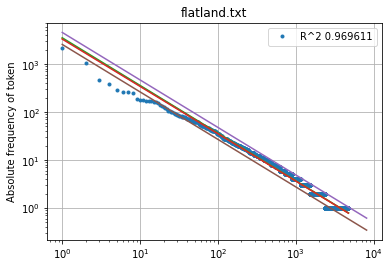

For the full data, we get the following linear regression
slope:     -1.069893    intercept: 9.200944
r_value:   -0.984859    p_value: 0.000000
std_error: 0.002320


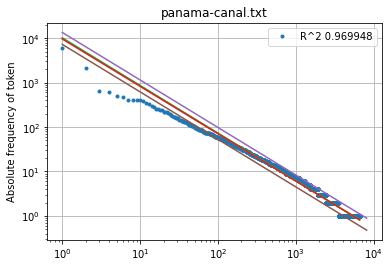

In [44]:
def results():
    for b in books:
        # Tokenize and count frequencies
        tokens_w_count = Counter(map(str.lower, books[b]))

        tokens = sorted([k for k in tokens_w_count.keys()])
        counts = np.array([tokens_w_count[k] for k in tokens])

        ranks = np.arange(1, len(counts) + 1)
        indices = np.argsort(-counts)
        freqs = counts[indices]
    
        # Fit regression
        fitted_val, lower_fit, upper_fit, upper_pred, lower_pred, r_sq, new_r = linreg(ranks, freqs, 0.95)
        zipf_plot(b, ranks, new_r, freqs, fitted_val, upper_fit, lower_fit, upper_pred, lower_pred, r_sq)

results()

### Task 6.

We would like to fit the power-law with exponential cutoff instead of standard zipf distribution. Repeat 2) and 3) and compare the fitting of the Zipf law to that of power-law with exponential cutoff for each of the two ebooks.

#### Power law with exponential cutoff

> $f(x) \propto x^{\alpha}e^{\beta x} $

In [ ]:
def pwlaw(x, alpha, beta):
    return x**alpha * exp(beta * x)

In [ ]:
for b in books:
        # Estimate alpha
        alpha = ahat(len(ranks[b]), ranks[b])
    
        # Fit curve
        total = sum([freqs[b]])
        plt.title(b)
        plt.scatter(ranks[b], freqs[b])
        plt.plot(ranks[b], pwlaw(freqs[b], 2.22, 0) * total, lw=1, color='red')
        plt.ylabel("Frequency")
        plt.xlabel("Rank")
        plt.xlim(0, 50) # limit x-axis to better see the fit
        plt.tight_layout()
        red_patch = matplotlib.patches.Patch(color='red', label='Fitted Zipf curve')
        plt.legend(handles=[red_patch])
        plt.show()

In [131]:
sts.powerlaw.fit(freqs["flatland.txt"])

(0.29904407400976585, 0.9999999999999998, 3037.226898696626)

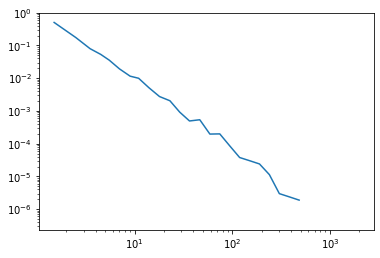

In [125]:
powerlaw.plot_pdf(freqs["flatland.txt"])